In [12]:
import pandas as pd
import numpy as np

file_readm = "/home/idies/workspace/Storage/ehan20/persistent/as.180.369/contrib/ElvisHan2022/Copy of FY 2019 IPPS Proposed Rule Readmissions Supplemental Data File.xlsx"
sheet_name = "NPRM FY 2019"

# --- Step 1 : Read first few rows (no header) to detect where "Hospital CCN" appears ---
preview = pd.read_excel(file_readm, sheet_name=sheet_name, header=None, nrows=10)

header_row = None
for i, row in preview.iterrows():
    if row.astype(str).str.contains("Hospital CCN", case=False, na=False).any():
        header_row = i
        break

if header_row is None:
    header_row = 0  # fallback if pattern not found

print(f"Detected header row = {header_row}")

# --- Step 2 : Read the sheet again using the detected header row ---
df = pd.read_excel(file_readm, sheet_name=sheet_name, header=header_row)

# --- Step 3 : Clean column names (strip spaces, collapse multiple spaces) ---
df.columns = (
    df.columns.astype(str)
    .str.replace("\xa0", " ", regex=False)     # remove non-breaking spaces
    .str.replace(r"\s+", " ", regex=True)      # collapse extra spaces
    .str.strip()
)

print("✅ Loaded HRRP sheet successfully!")
print("Shape:", df.shape)
print("First 10 columns:")
print(df.columns.tolist()[:10])


Detected header row = 1
✅ Loaded HRRP sheet successfully!
Shape: (3167, 35)
First 10 columns:
['Hospital CCN', 'FY 2019 Proposed Proxy Payment Adjustment Factor', 'Dual proportion', 'Peer group assignment', 'Neutrality modifier', 'Number of eligible discharges for AMI', 'ERR for AMI', 'Peer group median ERR for AMI', 'Penalty indicator for AMI', 'DRG payment ratio for AMI']


In [13]:
# ==============================================================
# STEP 4.  BUILD df_eda (EXPLORATORY DATASET)
# --------------------------------------------------------------
# We isolate the columns required for our descriptive and regression
# analyses.  Columns not in this list (e.g., documentation sheets)
# are ignored to reduce clutter.
# ==============================================================

cols_keep = [
    "Hospital CCN",
    "FY 2019 Proposed Proxy Payment Adjustment Factor",
    "Dual proportion",
    "Peer group assignment",
    "Neutrality modifier",

    # Condition-specific variables
    "Number of eligible discharges for AMI", "ERR for AMI", "Peer group median ERR for AMI", "Penalty indicator for AMI", "DRG payment ratio for AMI",
    "Number of eligible discharges for COPD", "ERR for COPD", "Peer group median ERR for COPD", "Penalty indicator for COPD", "DRG payment ratio for COPD",
    "Number of eligible discharges for HF", "ERR for HF", "Peer group median ERR for HF", "Penalty indicator for HF", "DRG payment ratio for HF",
    "Number of eligible discharges for Pneumonia", "ERR for Pneumonia", "Peer group median ERR for Pneumonia", "Penalty indicator for Pneumonia", "DRG payment ratio for Pneumonia",
    "Number of eligible discharges for CABG", "ERR for CABG", "Peer group median ERR for CABG", "Penalty indicator for CABG", "DRG payment ratio for CABG",
    "Number of eligible discharges for THA/TKA", "ERR for THA/TKA", "Peer group median ERR for THA/TKA", "Penalty indicator for THA/TKA", "DRG payment ratio for THA/TKA",
]

# Only keep columns that exist (avoids KeyErrors)
cols_present = [c for c in cols_keep if c in df.columns]
df_eda = df[cols_present].copy()

# Rename a few long variables for easier referencing later
df_eda = df_eda.rename(columns={
    "FY 2019 Proposed Proxy Payment Adjustment Factor": "A_h",  # Payment-Adjustment factor
    "Dual proportion": "DualShare",
    "Peer group assignment": "PeerGroup",
})

print("✅ Variables selected for EDA:", len(df_eda.columns))


✅ Variables selected for EDA: 35


In [14]:
# ==============================================================
# STEP 5.  CLEAN VALUES AND CREATE PENALTY FLAGS
# --------------------------------------------------------------
# 1. Replace text placeholders (e.g., "NQ") with NaN.
# 2. Coerce numeric columns.
# 3. Normalize Y/N penalty indicators.
# 4. Create binary flags:
#      • Penalized_any → 1 if A_h < 1
#      • Pen_AMI ... Pen_THA_TKA → 1 if CMS lists Y for that condition
# ==============================================================

df_eda = df_eda.replace("NQ", np.nan)

# Normalize penalty indicators and numeric variables
for c in df_eda.columns:
    if c.startswith("Penalty indicator"):
        df_eda[c] = df_eda[c].astype(str).str.upper().str.strip()
    else:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")

for c in ["A_h", "DualShare", "Neutrality modifier"]:
    if c in df_eda.columns:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

# Overall penalty status
df_eda["Penalized_any"] = np.where(df_eda["A_h"] < 1, 1, 0)

# Condition-specific penalty flags
cond_map = {
    "AMI": "Penalty indicator for AMI",
    "COPD": "Penalty indicator for COPD",
    "HF": "Penalty indicator for HF",
    "Pneumonia": "Penalty indicator for Pneumonia",
    "CABG": "Penalty indicator for CABG",
    "THA_TKA": "Penalty indicator for THA/TKA",
}
for k, col in cond_map.items():
    if col in df_eda.columns:
        df_eda[f"Pen_{k}"] = df_eda[col].map({"Y": 1, "N": 0}).astype("Int64")

print("✅ Data cleaned. Preview:")
display(df_eda.head(3))


✅ Data cleaned. Preview:


/tmp/ipykernel_4258/3316998736.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eda = df_eda.replace("NQ", np.nan)
/tmp/ipykernel_4258/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_4258/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_4258/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric wi

,Hospital CCN,A_h,DualShare,PeerGroup,Neutrality modifier,Number of eligible discharges for AMI,ERR for AMI,Peer group median ERR for AMI,Penalty indicator for AMI,DRG payment ratio for AMI,Number of eligible discharges for COPD,ERR for COPD,Peer group median ERR for COPD,Penalty indicator for COPD,DRG payment ratio for COPD,Number of eligible discharges for HF,ERR for HF,Peer group median ERR for HF,Penalty indicator for HF,DRG payment ratio for HF,Number of eligible discharges for Pneumonia,ERR for Pneumonia,Peer group median ERR for Pneumonia,Penalty indicator for Pneumonia,DRG payment ratio for Pneumonia,Number of eligible discharges for CABG,ERR for CABG,Peer group median ERR for CABG,Penalty indicator for CABG,DRG payment ratio for CABG,Number of eligible discharges for THA/TKA,ERR for THA/TKA,Peer group median ERR for THA/TKA,Penalty indicator for THA/TKA,DRG payment ratio for THA/TKA,Penalized_any,Pen_AMI,Pen_COPD,Pen_HF,Pen_Pneumonia,Pen_CABG,Pen_THA_TKA
0,010001,0.9941,0.165328,2.0,0.948106,810.0,0.987485,0.996365,N,0.045309,617.0,0.989062,0.991102,N,0.017674,1053.0,0.950565,0.986273,N,0.034367,656.0,1.085531,0.978269,Y,0.023627,275.0,1.049896,0.994634,Y,0.032878,342.0,1.100402,0.990957,Y,0.017070,1,0,0,0,1,1,1
1,010005,0.9860,0.162036,2.0,0.948106,53.0,0.969510,0.996365,N,0.006251,627.0,0.872445,0.991102,N,0.046060,362.0,1.098955,0.986273,Y,0.027815,841.0,0.919161,0.978269,N,0.074398,NaN,NaN,0.994634,N,NaN,263.0,1.311051,0.990957,Y,0.036328,1,0,0,1,0,0,1
2,010006,0.9864,0.116248,1.0,0.948106,395.0,1.041671,0.995627,Y,0.034242,693.0,0.993457,0.992562,Y,0.026145,885.0,1.001416,0.978613,Y,0.041299,942.0,1.052887,0.986408,Y,0.046545,147.0,1.100749,0.993422,Y,0.025937,411.0,1.185131,0.987525,Y,0.029990,1,1,1,1,1,1,1


In [15]:
# ==============================================================
# STEP 6.  DEFINE EASY SUMMARY FUNCTION
# --------------------------------------------------------------
# This helper produces simple descriptive statistics for any
# numeric column: count, mean, SD, min, quartiles, and max.
# ==============================================================

def easy_summary(series, name):
    s = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "count": int(s.notna().sum()),
        "missing": int(s.isna().sum()),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "p25": s.quantile(0.25),
        "median": s.median(),
        "p75": s.quantile(0.75),
        "max": s.max(),
    }, name=name)


In [21]:
# ==============================================================
# STEP 8.  SUMMARIZE EXCESS READMISSION RATIOS (ERR)
# --------------------------------------------------------------
# For each monitored condition, compute central tendency and spread.
# These variables capture hospital performance under HRRP.
# ==============================================================

err_cols = [c for c in df_eda.columns if str(c).startswith("ERR for ")]
err_summary_df = pd.DataFrame([easy_summary(df_eda[c], c) for c in err_cols])

print("=== Excess Readmission Ratios (ERR) by Condition ===")
display(err_summary_df.round(4))


=== Excess Readmission Ratios (ERR) by Condition ===


,count,missing,mean,std,min,p25,median,p75,max
ERR for AMI,2928.0,239.0,1.0010,0.0526,0.7518,0.9755,0.9975,1.0253,1.2380
ERR for COPD,3041.0,126.0,1.0012,0.0603,0.8143,0.9630,0.9969,1.0363,1.3544
ERR for HF,3025.0,142.0,1.0016,0.0754,0.7170,0.9539,0.9990,1.0459,1.4113
ERR for Pneumonia,3052.0,115.0,1.0018,0.0813,0.7635,0.9479,0.9964,1.0512,1.3615
ERR for CABG,1154.0,2013.0,1.0038,0.0945,0.7095,0.9441,0.9972,1.0573,1.5085
ERR for THA/TKA,2808.0,359.0,1.0077,0.1318,0.5612,0.9282,0.9942,1.0736,1.7293


In [23]:
# ==============================================================
# STEP 10.  PENALTY INCIDENCE
# --------------------------------------------------------------
# Measures how many hospitals were penalized overall (A_h<1)
# and for each condition (Y/N in CMS indicator fields).
# ==============================================================

total_hosp = len(df_eda)
rows = []

# Overall
if "Penalized_any" in df_eda.columns:
    n_any = int(df_eda["Penalized_any"].sum())
    pct_any = round(100 * n_any / total_hosp, 1)
    rows.append(pd.Series({
        "Hospitals penalized": n_any,
        "Share penalized (%)": pct_any,
        "N (hospitals)": total_hosp
    }, name="Overall (A_h < 1)"))

# Condition-specific
for k in ["AMI","COPD","HF","Pneumonia","CABG","THA_TKA"]:
    col = f"Pen_{k}"
    if col in df_eda.columns:
        n = int(df_eda[col].sum(skipna=True))
        denom = int(df_eda[col].notna().sum())
        pct = round(100 * n / denom, 1)
        rows.append(pd.Series({
            "Hospitals penalized": n,
            "Share penalized (%)": pct,
            "N (hospitals)": denom
        }, name=k))

penalty_table = pd.DataFrame(rows)
print("=== Penalty Incidence (Overall and by Condition) ===")
display(penalty_table)


=== Penalty Incidence (Overall and by Condition) ===


,Hospitals penalized,Share penalized (%),N (hospitals)
Overall (A_h < 1),2610.0,82.4,3167.0
AMI,1088.0,34.4,3166.0
COPD,1413.0,44.6,3166.0
HF,1419.0,44.8,3166.0
Pneumonia,1452.0,45.9,3166.0
CABG,502.0,15.9,3166.0
THA_TKA,1212.0,38.3,3166.0


In [24]:
# ==============================================================
# STEP 11.  COMPARE PENALIZED VS NON-PENALIZED HOSPITALS
# --------------------------------------------------------------
# This section explores whether penalized hospitals systematically
# differ in socioeconomic composition (DualShare) or performance (ERR).
# ==============================================================

# Label each hospital
df_eda["Penalized_label"] = np.where(df_eda["A_h"] < 1, "Penalized", "Not Penalized")

# Variables to compare
compare_vars = ["DualShare", "Neutrality modifier", "PeerGroup"] + [c for c in df_eda.columns if c.startswith("ERR for ")]

# Group means and differences
group_means = df_eda.groupby("Penalized_label")[compare_vars].mean(numeric_only=True).T
group_means.columns = [f"Mean ({c})" for c in group_means.columns]
if {"Mean (Penalized)", "Mean (Not Penalized)"} <= set(group_means.columns):
    group_means["Difference"] = group_means["Mean (Penalized)"] - group_means["Mean (Not Penalized)"]

print("=== Mean Comparison: Penalized vs Not Penalized ===")
display(group_means.round(4))


=== Mean Comparison: Penalized vs Not Penalized ===


,Mean (Not Penalized),Mean (Penalized),Difference
DualShare,0.2318,0.2453,0.0135
Neutrality modifier,0.9481,0.9481,0.0000
PeerGroup,2.8058,3.0406,0.2349
ERR for AMI,0.9678,1.0059,0.0381
ERR for COPD,0.9643,1.0077,0.0434
ERR for HF,0.9502,1.0104,0.0602
ERR for Pneumonia,0.9445,1.0121,0.0676
ERR for CABG,0.9193,1.0121,0.0928
ERR for THA/TKA,0.9137,1.0235,0.1097


In [32]:
# ==============================================================
# STEP 9.  PEER-GROUP DISTRIBUTION
# --------------------------------------------------------------
# CMS groups hospitals into 4 peer groups by dual-eligible share.
# This shows the frequency and percentage of hospitals in each group.
# ==============================================================

if "PeerGroup" in df_eda.columns:
    pg_counts = df_eda["PeerGroup"].value_counts(dropna=False).sort_index()
    peer_table = pd.DataFrame({
        "count": pg_counts,
        "percent": (pg_counts / pg_counts.sum() * 100).round(1)
    })
    print("=== Peer Group Distribution (1–4) ===")
    display(peer_table)


=== Peer Group Distribution (1–4) ===


,count,percent
PeerGroup,,
1.0,632,20.0
2.0,636,20.1
3.0,633,20.0
4.0,632,20.0
5.0,633,20.0
NaN,1,0.0


In [28]:
# ==============================================================
# STEP 13.  SETUP FOR REDUCED-FORM REGRESSIONS
# --------------------------------------------------------------
# We use statsmodels for OLS estimation.
# ==============================================================

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9934      0.000   4149.207      0.000       0.993       0.994
DualShare      0.0033      0.001      3.884      0.000       0.002       0.005


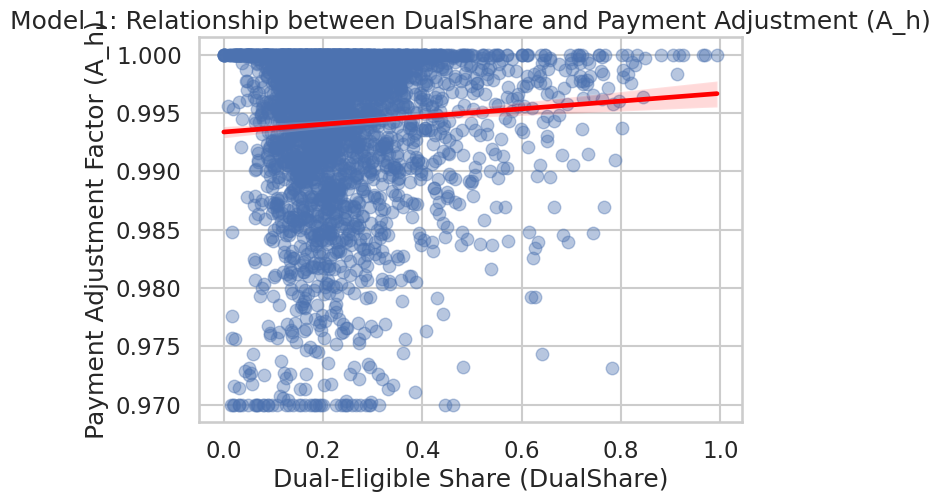

In [30]:
# ==============================================================
# MODEL 1: Relationship between Payment Adjustment (A_h)
#           and Dual-Eligible Proportion (DualShare)
# --------------------------------------------------------------
# Intuition: Are hospitals serving poorer populations more likely
# to face larger payment cuts under HRRP?
# ==============================================================

model1 = smf.ols("A_h ~ DualShare", data=df_eda).fit()
print(model1.summary().tables[1])

# Visualization: Scatter + fitted regression line
plt.figure(figsize=(7,5))
sns.regplot(x="DualShare", y="A_h", data=df_eda, scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
plt.title("Model 1: Relationship between DualShare and Payment Adjustment (A_h)")
plt.xlabel("Dual-Eligible Share (DualShare)")
plt.ylabel("Payment Adjustment Factor (A_h)")
plt.show()


                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9937      0.000   3083.824      0.000       0.993       0.994
C(PeerGroup)[T.2.0] -7.396e-05      0.000     -0.184      0.854      -0.001       0.001
C(PeerGroup)[T.3.0]    -0.0002      0.000     -0.395      0.693      -0.001       0.001
C(PeerGroup)[T.4.0]  1.038e-05      0.001      0.021      0.984      -0.001       0.001
C(PeerGroup)[T.5.0]     0.0007      0.001      0.848      0.397      -0.001       0.002
DualShare               0.0017      0.002      0.934      0.350      -0.002       0.005


/tmp/ipykernel_4258/1884409490.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PeerGroup", y="A_h", data=df_eda, palette="Set3")


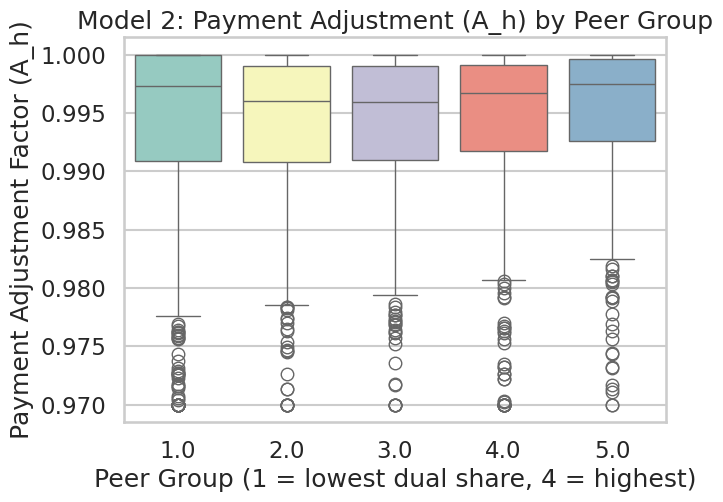

In [31]:
# ==============================================================
# MODEL 2: Add categorical PeerGroup to capture non-linear equity effects
# --------------------------------------------------------------
# Each peer group represents a quartile of DualShare.
# We include it as categorical to compare penalties across groups.
# ==============================================================

model2 = smf.ols("A_h ~ DualShare + C(PeerGroup)", data=df_eda).fit()
print(model2.summary().tables[1])

# Visualization: Boxplot of A_h by PeerGroup
plt.figure(figsize=(7,5))
sns.boxplot(x="PeerGroup", y="A_h", data=df_eda, palette="Set3")
plt.title("Model 2: Payment Adjustment (A_h) by Peer Group")
plt.xlabel("Peer Group (1 = lowest dual share, 4 = highest)")
plt.ylabel("Payment Adjustment Factor (A_h)")
plt.show()
